In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd ~/bmi_dynamics_code

/Users/preeyakhanna/bmi_dynamics_code


In [4]:
from online_analysis import util_fcns
import analysis_config

In [5]:
import seaborn
seaborn.set(font='Arial',context='talk',font_scale=1.2, style='white')


In [29]:
2*22/3.

14.666666666666666

In [3]:
### load data to make R2 plots -- compute residuals, 
### plot residuals as a fcn of time

Animal grom
30.0
Animal jeev
22.0


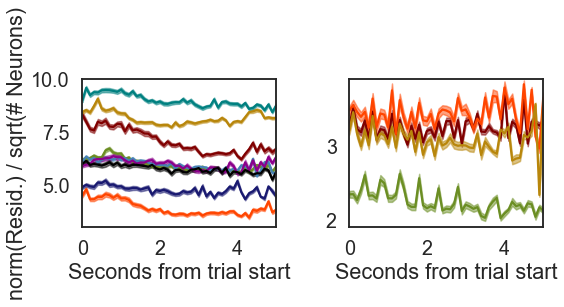

In [8]:
# fig, ax = plt.subplots(figsize =(5, 5))
fig, ax = plt.subplots(ncols = 2, figsize =(8, 4))

mag_boundaries = pickle.load(open(analysis_config.data_params['mag_bound_file'], 'rb'))

colors = analysis_config.pref_colors
#colors = ['gray']

## store data for linear mixed effects stats later
LME = dict(animal_day=[], early_late=[], norm=[])

total_trials = 0; 
count_trial = 0; 

animal_windows = {}
### Early / late windows 
animal_windows['grom'] = [np.arange(10), np.arange(20, 30)]
animal_windows['jeev'] = [np.arange(8), np.arange(15, 22)]
R2_time = {}

for ia, animal in enumerate(['grom', 'jeev']):
    
    #### models ########
    fname = analysis_config.config[animal+'_pref']+'tuning_models_%s_model_set6_.pkl'%animal
    dat_ridge = pickle.load(open(fname, 'rb'))#, **pkl_kw)

    #### predict forward #######
    #R2_pred_next_spks = []
    #R2_pred_next_command = []
    R2_w_time = []
    
    #### ndays ######
    ndays = analysis_config.data_params['%s_ndays'%animal] 
    len_trl = []
    
    for day_ix in range(ndays):  
        r2_w_time = []
        
        #### spks true #####
        spks      = dat_ridge[day_ix, 'spks']

        ### ridge spks #####
        pred_spks = dat_ridge[day_ix, 'hist_1pos_0psh_0spksm_1_spksp_0'] ## no conditioning 
        
        ### Quick comparison for now ### 
        neural_push = dat_ridge[day_ix, 'np']

        command_bins = util_fcns.commands2bins([neural_push], mag_boundaries, animal, day_ix, 
                                           vel_ix=[0, 1])[0]
        
        ### Get these out for SLDS data comparison ### 
        bin_num = dat_ridge[day_ix, 'bin_num']
        
        for b in np.sort(np.unique(bin_num)): 
            bix = np.nonzero(bin_num == b)[0]
            if len(bix) > 10: 
                r2_w_time.append(util_fcns.get_R2(spks[bix, :], pred_spks[bix, :]))
        R2_w_time.append(r2_w_time)
        
        ### max - min 
        max_bin = np.max(bin_num)
        min_bin = np.min(bin_num)
        
        trl = dat_ridge[day_ix, 'trl']
        
        day_norms = np.zeros((len(np.unique(trl)), max_bin-min_bin+1, ))
        day_norms[:] = np.nan 
        
        ### Compile norm of residual for each trial 
        for i_t, trl_i in enumerate(np.unique(trl)): 
            
            ### trl indices ### 
            trl_ix = np.nonzero(trl == trl_i)[0]
            
            len_trl.append(len(trl_ix))
            
            for i_b, bin_num_i in enumerate(np.sort(bin_num[trl_ix])): 
                
                ix_ = np.nonzero(bin_num[trl_ix] == bin_num_i)[0]
                assert(len(ix_) == 1)
                
                ### Residual 
                resid = spks[trl_ix[ix_], :] - pred_spks[trl_ix[ix_], :]
                
                ### Norm / sqrt(# neurons)
                day_norms[i_t, i_b] = np.linalg.norm(resid)/np.sqrt(len(resid))
                
                if (np.max(bin_num[trl_ix])) >= animal_windows[animal][1][1]: 
                    if i_b == animal_windows[animal][0][-1]: 
                        LME['animal_day'].append(ia*10 + day_ix)
                        LME['early_late'].append(0) # early 
                        LME['norm'].append(np.mean(day_norms[i_t, animal_windows[animal][0]]))
#                     elif i_b == 20: 
#                         LME['animal_day'].append(ia*10 + day_ix)
#                         LME['early_late'].append(1) # mid 
#                         LME['norm'].append(np.mean(day_norms[i_t, i_b-10:i_b]))
                    elif i_b == animal_windows[animal][1][-1]: 
                        LME['animal_day'].append(ia*10 + day_ix)
                        LME['early_late'].append(2) # mid 
                        LME['norm'].append(np.mean(day_norms[i_t, animal_windows[animal][1]]))
                        count_trial += 1
            total_trials += 1
                        
        ### Plot the norm 
        #if animal == 'grom' and day_ix == 0: 
        T = np.arange(day_norms.shape[1])*.1

        #mn = np.nanmean(day_norms, axis=0)
        #day_norms = day_norms / mn[0]; # Normalize by first timepoint 

        mn = np.nanmean(day_norms, axis=0)
        st = np.nanstd(day_norms, axis=0)/np.sqrt(day_norms.shape[0])

        ax[ia].fill_between(T, mn-st, mn+st, color=colors[day_ix], alpha=0.5)
        ax[ia].plot(T, mn, '-',color=colors[day_ix])
                
    ### Print avg trl length
    print('Animal %s' %(animal))
    print(np.median(len_trl))
    
    R2_time[animal] = R2_w_time
  
for axi in ax: 
    axi.set_xlim([0, 5.])
    
#ax.vlines(3., 0, 10, 'k', linestyle='dashed')
#ax.set_ylim([6., 9.])
#ax[1].set_xlim([0, 2.2])

ax[0].set_ylim([3., 10.])
ax[1].set_ylim([1.9, 3.9])

ax[0].set_ylabel('norm(Resid.) / sqrt(# Neurons)')
ax[0].set_xlabel('Seconds from trial start')
ax[1].set_xlabel('Seconds from trial start') 
plt.tight_layout()
#util_fcns.savefig(fig, 'eg_input_psth')

Animal grom stats: 
PV = 3.867e-137
SLP -0.24169, N = 4748, t(4746) = -24.926



Animal jeev stats: 
PV = 8.583e-08
SLP -0.06254, N = 1163, t(1161) = -5.354





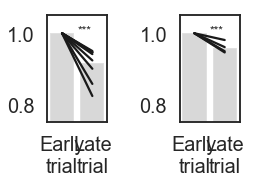

In [7]:
norm = True#False
f, ax = plt.subplots(ncols = 2, figsize=(4, 3))

LME['animal_day'] = np.hstack((LME['animal_day']))
LME['early_late'] = np.hstack((LME['early_late']))
LME['norm'] = np.hstack((LME['norm']))

###### Plotting ######
for ia, animal in enumerate(['grom', 'jeev']): 
    ndays = analysis_config.data_params['%s_ndays'%animal] 
    EL = []; 
    
    for day_ix in range(ndays): 
        ix = np.nonzero(LME['animal_day'] == (ia*10 + day_ix))[0]
        
        e_ix = np.nonzero(LME['early_late'][ix] == 0)[0]
        #m_ix = np.nonzero(LME['early_late'][ix] == 1)[0]
        l_ix = np.nonzero(LME['early_late'][ix] == 2)[0]
        
        E = np.mean(LME['norm'][ix[e_ix]])
        #M = np.mean(LME['norm'][ix[m_ix]])
        L = np.mean(LME['norm'][ix[l_ix]])
        
        if norm: 
            L = L/E; 
            E = E/E; 
        
        ax[ia].plot(np.arange(2), np.array([E, L]), 'k-')
        EL.append([E, L])
        
    EL = np.vstack((EL))
    ax[ia].bar(0, np.mean(EL[:, 0]), width=.8, alpha=.3, color='gray')
    ax[ia].bar(1, np.mean(EL[:, 1]), width=.8, alpha=.3, color='gray')

    #### print LME ########
    animal_ix = np.nonzero(LME['animal_day'] >= (ia*10))[0]
    print('Animal %s stats: '%animal)
    util_fcns.run_LME(LME['animal_day'][animal_ix], 
                      LME['early_late'][animal_ix],
                      LME['norm'][animal_ix])
    print('')
    print('')
    print('')
    
if norm: 
    ax[0].text(0.5, 1., '***', fontsize=12)
    ax[1].text(0.5, 1., '***', fontsize=12)

    ax[0].set_ylim([.75, 1.05])
    ax[1].set_ylim([.75, 1.05])

else: 
    ax[0].text(0.5, 9.4, '***', fontsize=12)
    ax[1].text(0.5, 3.5, '***', fontsize=12)

    ax[0].set_ylim([3.4, 10.2])
    ax[1].set_ylim([2.2, 3.7])

for axi in ax: 
    axi.set_xticks([0, 1])
    axi.set_xticklabels(['Early\ntrial', 'Late\ntrial'])
if norm: 
    pass
else:
    ax[0].set_ylabel('norm(Resid.) / \nsqrt(# Neurons)')
plt.tight_layout()
util_fcns.savefig(f, 'bar_plots_early_vs_late_trial')

In [42]:
float(count_trial) / total_trials

0.7964922048997772

In [13]:
%matplotlib notebook

Animal grom stats: 
PV = 9.654e-07
SLP -0.04199, N = 18, t(16) = -4.899



Animal jeev stats: 
PV = 1.516e-07
SLP -0.05316, N = 26, t(24) = -5.251





/Users/preeyakhanna/conda/envs/py27/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/preeyakhanna/conda/envs/py27/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Text(0,0.5,'R2')

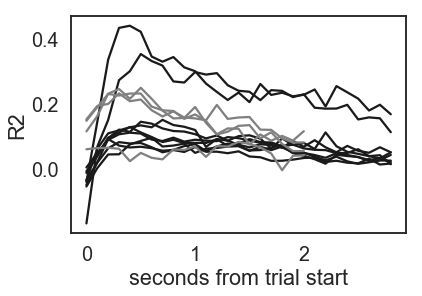

In [27]:
###### Early / late #####
LME2 = {}
LME2['animal_day'] = []
LME2['early_late'] = []
LME2['r2'] = []

###### Plot R2 time ######
f, ax = plt.subplots()
color = dict(grom='k', jeev='gray')
for i_a, animal in enumerate(['grom', 'jeev']): 
    T = animal_windows[animal][1][-1]
    for i_d, d in enumerate(R2_time[animal]): 
        d = np.array(d)
        ax.plot(np.arange(T)/10., d[:T], '-', color=color[animal])
    
        LME2['animal_day'].append(i_a*10 + i_d)
        LME2['early_late'].append(0)
        LME2['r2'].append(np.mean(d[animal_windows[animal][0]]))
        
        LME2['animal_day'].append(i_a*10 + i_d)
        LME2['early_late'].append(1)
        LME2['r2'].append(np.mean(d[animal_windows[animal][1]]))
        
    ### Animal specific stats
    print('Animal %s stats: '%animal)
    util_fcns.run_LME(LME2['animal_day'], 
                      LME2['early_late'],
                      LME2['r2'])
    print('')
    print('')
    print('')
    
        
ax.set_xlabel('seconds from trial start')
ax.set_ylabel('R2')

In [25]:
animal_windows[animal][0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])